In [68]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU,Dropout
import librosa

In [69]:
def df_to_vector_array(df,
                       sampling_rate = 48000,
                       hop_length = 2048,
                       n_fft = 65536):
    ample_array = np.array(df.loc[:,'ample'])
    n_fft = n_fft

    # フレームごとのシフトサイズ（一般的には `n_fft // 4` など）
    hop_length = hop_length

    # メルスペクトログラムの生成
    mel_spectrogram = librosa.feature.melspectrogram(y=ample_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)

    # MFCC の計算 (13係数で設定)
    mfccs = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=13)

    return mfccs

In [70]:
sampling_rate = 48000
df = pd.read_csv('../data/20240509/raw/mic_normal1.csv')
mfccs = df_to_vector_array(df, sampling_rate = sampling_rate)

In [71]:
mfccs.shape

(13, 1405)

In [72]:
training_data = []

for i in range(8):
    if(i == 3 or i == 7):
        continue
    path_to_coodinate = f'../data/20240509/raw/coordinates_normal{i}.csv'
    path_to_sound = f'../data/20240509/raw/mic_normal{i}.csv'
    coordinate_df = pd.read_csv(path_to_coodinate)
    
    sound_df = pd.read_csv(path_to_sound)
    mfccs = df_to_vector_array(sound_df)
    time_stamp = [(16384/2+i*2048) /48000 for i in range(mfccs.shape[1])]
    mfcc_df = pd.DataFrame({
        'time': time_stamp
    })
    
    for j in range(13):
        mfcc_df[f'mfcc_{j}'] = mfccs[j]
    merged_data = pd.merge_asof(mfcc_df, coordinate_df, on='time', direction='nearest')
    merged_data.to_csv(f'../data/20240509/processed_mel_spectrogram/mfcc_coordinate{i}.csv')


In [73]:
training_data = []
x_train = []
y_train = []
data_frames = []

for i in range(8):
    if(i == 3 or i == 7):
        continue
    path_to_mfcc_coord = f'../data/20240509/processed/mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames.append(df)
    
combined_df = pd.concat(data_frames, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_train = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_train = combined_df[x_columns_to_use].values


In [74]:
training_data = []

for i in range(2):
    path_to_coodinate = f'../data/20240509/raw/coordinates_abnormal{i}.csv'
    path_to_sound = f'../data/20240509/raw/mic_abnormal{i}.csv'
    coordinate_df = pd.read_csv(path_to_coodinate)
    
    sound_df = pd.read_csv(path_to_sound)
    mfccs = df_to_vector_array(sound_df)
    time_stamp = [(16384/2+i*2048) /48000 for i in range(mfccs.shape[1])]
    mfcc_df = pd.DataFrame({
        'time': time_stamp
    })
    
    for j in range(13):
        mfcc_df[f'mfcc_{j}'] = mfccs[j]
    merged_data = pd.merge_asof(mfcc_df, coordinate_df, on='time', direction='nearest')
    merged_data.to_csv(f'../data/20240509/processed/abnormal_mfcc_coordinate{i}.csv')
data_frames_abnormal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/abnormal_mfcc_coordinate{i}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_abnormal.append(df)
    
combined_df = pd.concat(data_frames_abnormal, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_test_abnormal = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_abnormal = combined_df[x_columns_to_use].values

In [75]:
for i in range(2):
    path_to_coodinate = f'../data/20240509/raw/coordinates_normal{i*4+3}.csv'
    path_to_sound = f'../data/20240509/raw/mic_normal{i*4+3}.csv'
    coordinate_df = pd.read_csv(path_to_coodinate)
    
    sound_df = pd.read_csv(path_to_sound)
    mfccs = df_to_vector_array(sound_df)
    time_stamp = [(16384/2+i*2048) /48000 for i in range(mfccs.shape[1])]
    mfcc_df = pd.DataFrame({
        'time': time_stamp
    })
    
    for j in range(13):
        mfcc_df[f'mfcc_{j}'] = mfccs[j]
    merged_data = pd.merge_asof(mfcc_df, coordinate_df, on='time', direction='nearest')
    merged_data.to_csv(f'../data/20240509/processed/normal_mfcc_coordinate{i*4+3}.csv')

data_frames_normal = []

for i in range(2):
    path_to_mfcc_coord = f'../data/20240509/processed/normal_mfcc_coordinate{i*4+3}.csv'
    df = pd.read_csv(path_to_mfcc_coord)
    data_frames_normal.append(df)
    
combined_df = pd.concat(data_frames_normal, ignore_index=True)

y_columns_to_use = [f'mfcc_{i}' for i in range(13)]

y_test_normal = combined_df[y_columns_to_use].values

x_columns_to_use = ['x','y']
x_test_normal = combined_df[x_columns_to_use].values

In [76]:
class Decoder(Model):
    def __init__(self, layer_num, input_dim=2, output_dim=13,dropout_ratio = 0.1):
        super(Decoder, self).__init__()
        self.layer_num = layer_num
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.hidden_layers = []
        for i in range(layer_num):
            nodes = 2 ** (i + 1)
            self.hidden_layers.append(Dense(nodes, activation='linear'))
            self.hidden_layers.append(BatchNormalization())
            self.hidden_layers.append(LeakyReLU(alpha=0.01))
            self.hidden_layers.append(Dropout(rate = dropout_ratio))

        self.dense_output = Dense(output_dim, activation='sigmoid')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.dense_output(x)
        return x

In [77]:
class SAMModel(tf.keras.models.Model):
    def __init__(self, base_model, *args, rho=0.05, **kwargs):
        super().__init__( *args, **kwargs)
        self.rho = tf.constant(rho, dtype=tf.float32)
        self.base_model = base_model  

    def call(self, inputs):
        return self.base_model(inputs)  

    def train_step(self,data):
        x, y = data

        # 1st step
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        norm = tf.linalg.global_norm(gradients)
        scale = self.rho / (norm + 1e-12)
        e_w_list = []
        for v, grad in zip(trainable_vars, gradients):
            e_w = grad * scale
            v.assign_add(e_w)
            e_w_list.append(e_w)

        # 2nd step
        with tf.GradientTape() as tape:
            y_pred_adv = self(x, training=True)
            loss_adv = self.compiled_loss(y, y_pred_adv, regularization_losses=self.losses)
        gradients_adv = tape.gradient(loss_adv, trainable_vars)
        for v, e_w in zip(trainable_vars, e_w_list):
            v.assign_sub(e_w)

        # optimize
        self.optimizer.apply_gradients(zip(gradients_adv, trainable_vars))

        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}
inputs = tf.keras.layers.Input(shape=(2,))
base_model = Decoder(layer_num=6, input_dim=2, output_dim=13,dropout_ratio = 0)
model = SAMModel(base_model = base_model, rho=0.05)
# model = base_model
model.compile(loss="mse", optimizer="Adam")
model.summary()

c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sam_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_1 (Decoder)             │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [78]:
def min_max_scaler(arr,min_val,max_val):
    arr = (arr-min_val)/(max_val-min_val)   
    arr = np.where(arr < 0, 0, arr)
    arr = np.where(arr > 1, 1, arr)
    return arr


std_weight = 3
for idx in range(y_train.shape[1]):
    mean_val = y_train[:,idx].mean()
    std_val = y_train[:,idx].std()
    max_val = mean_val + std_weight*std_val
    min_val = mean_val - std_weight*std_val
    y_train[:,idx] = min_max_scaler(y_train[:,idx], min_val, max_val)
    y_test_abnormal[:,idx] = min_max_scaler(y_test_abnormal[:,idx], min_val, max_val)
    y_test_normal[:,idx] = min_max_scaler(y_test_normal[:,idx], min_val, max_val)

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(
    x_train, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=True, 
    callbacks=[callback]
)

Epoch 1/100


c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:618: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight)`.
  warnings.warn(
c:\Users\kenta\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:593: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.5005 - val_loss: 0.0236
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4944 - val_loss: 0.0205
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4985 - val_loss: 0.0192
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4971 - val_loss: 0.0187
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4980 - val_loss: 0.0186
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4993 - val_loss: 0.0188
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4988 - val_loss: 0.0187
Epoch 8/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4975 - val_loss: 0.0188
Epoch 9/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4983 - val_loss: 0.0186
Epoch 10/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4999 - val_loss: 0.0188
Epoch 11/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4978 - val_loss: 0.0187
Epoch 12/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


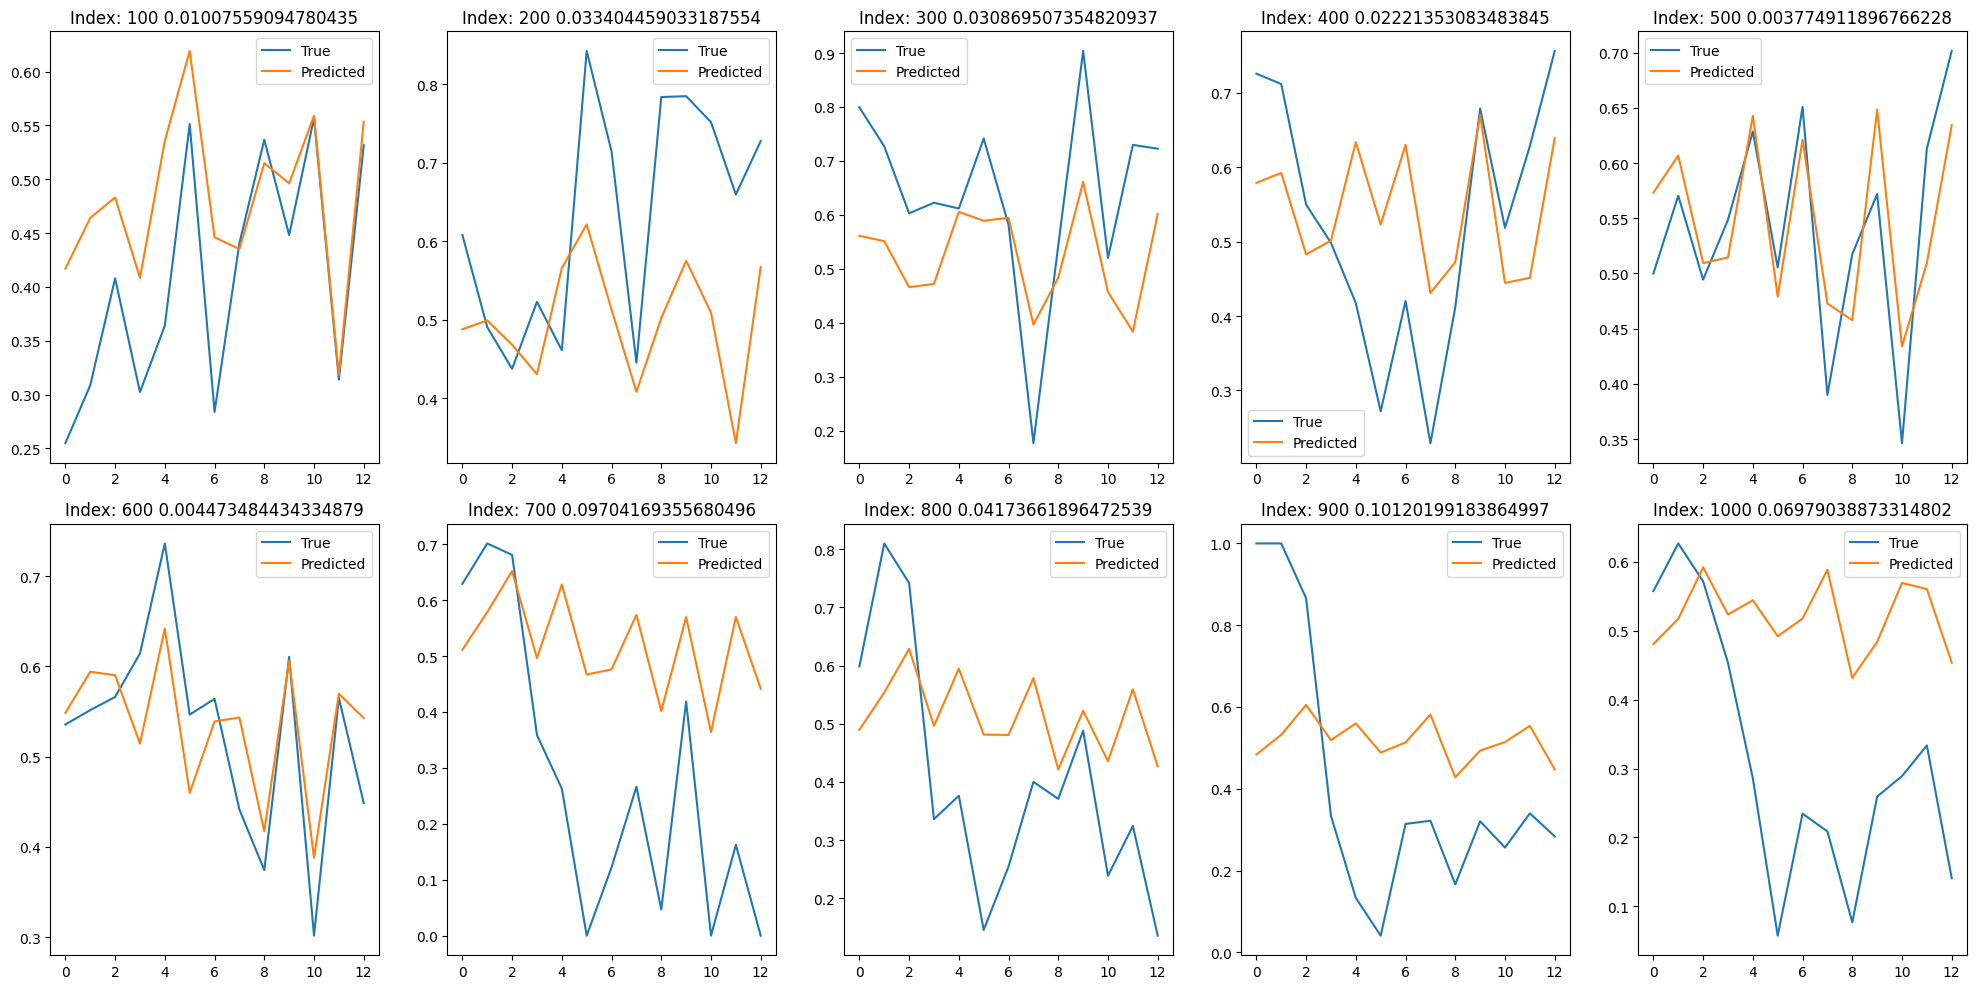

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error


# Configuration
start_index = 100  # Starting point for the graphs
num_graphs = 10  # Number of subplots to generate
index_step = 100  # Index increment between graphs

# Set up the figure and the subplots grid
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))  # Adjust rows/columns as needed
axs = axs.flatten()  # Flattening to easily index

# Plot each graph in a separate subplot
for i in range(num_graphs):
    current_index = start_index + i * index_step
    x = np.expand_dims(x_test_normal[current_index], axis=0)  # Adjust input shape if necessary
    y_predicted = model.predict(x)
    y_predicted = np.squeeze(y_predicted)
    
    # 平均二乗誤差を計算
    mse = mean_squared_error(y_predicted, y_test_normal[current_index])
    
    # Plot original vs predicted in the current subplot
    axs[i].plot(y_test_normal[current_index].T, label='True')
    axs[i].plot(y_predicted.T, label='Predicted')
    
    axs[i].set_title(f'Index: {current_index} {mse}')
    axs[i].legend()

# Adjust the layout to prevent overlap and show the plot
plt.tight_layout()
plt.show()


In [81]:
y_predicted_normal = model.predict(x_test_normal)
y_predicted_abnormal = model.predict(x_test_abnormal)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [82]:
print(y_predicted_normal.shape, y_test_normal.shape)

(2456, 13) (2456, 13)


In [83]:
mses_normal = []
for i in range(y_predicted_normal.shape[0]):
    mse = mean_squared_error(y_predicted_normal[i],y_test_normal[i])
    mses_normal.append(mse)

In [84]:
mses_abnormal = []
for i in range(y_predicted_abnormal.shape[0]):
    mse = mean_squared_error(y_predicted_abnormal[i],y_test_abnormal[i])
    mses_abnormal.append(mse)

In [106]:
def gaussian_2d(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(xo)
    yo = float(yo)
    x = x - xo
    y = y - yo
    sigma_x = float(sigma_x)
    sigma_y = float(sigma_y)

    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)

    g = offset + amplitude * np.exp(-(a * ((x)**2) + 2*b*x*y + c * ((y)**2)))
    return g.ravel()

# データの準備
x_data = x_test_abnormal[:, 0]
y_data = x_test_abnormal[:, 1]
z_data = mses_abnormal

# 初期パラメータの設定
initial_guess = (1, np.mean(x_data), np.mean(y_data), np.std(x_data), np.std(y_data), 0, np.min(z_data))

# フィッティング実行
popt, pcov = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_guess)

# 結果の表示
print("フィット結果: 振幅={}, X中心={}, Y中心={}, X幅={}, Y幅={}, 角度={}, オフセット={}".format(*popt))


フィット結果: 振幅=0.08255242597073514, X中心=0.27662015762168135, Y中心=0.027317502771644672, X幅=0.17092898435496492, Y幅=0.6529922518137401, 角度=1.612574703858251, オフセット=0.04446096595191462


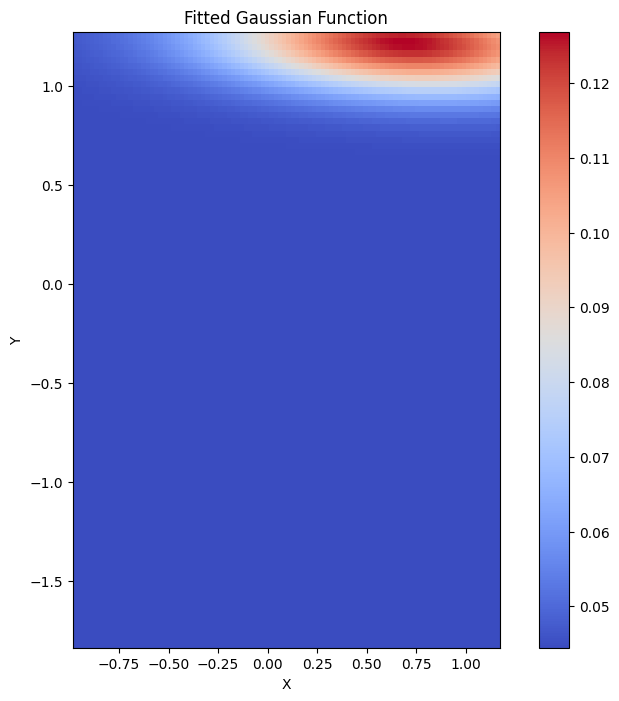

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# フィッティングされたパラメータを使用
amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt

# 座標グリッドを生成
x = np.linspace(x_data.min(), x_data.max(), 100)
y = np.linspace(y_data.min(), y_data.max(), 100)
xgrid, ygrid = np.meshgrid(x, y)

# ガウス関数を計算
zgrid = gaussian_2d((xgrid, ygrid), amplitude, xo, yo, sigma_x, sigma_y, theta, offset)

# ヒートマップを表示
plt.figure(figsize=(10, 8))
plt.imshow(zgrid.reshape(100, 100), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='coolwarm')
plt.colorbar()
plt.title('Fitted Gaussian Function')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [88]:
max(x_test_abnormal[:,1])
new_ls = set(x_test_abnormal[:,1])
new_ls.remove(max(new_ls))
result = max(new_ls) #２番目に大きい値を取得

In [89]:
(0.98, 1.26)

(0.98, 1.26)

In [90]:
print(result)

1.2674202403961854


In [91]:
#x_test_normalとx_test_abnormalを原点を基準とした座標に変換
x_test_normal = (x_test_normal - [0.98, 1.26])*-1
x_test_abnormal = (x_test_abnormal - [0.98, 1.26])*-1

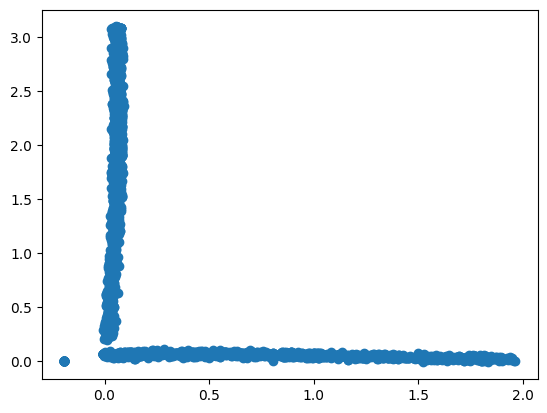

In [92]:
plt.plot(x_test_abnormal[:,0], x_test_abnormal[:,1], 'o', label='abnormal')

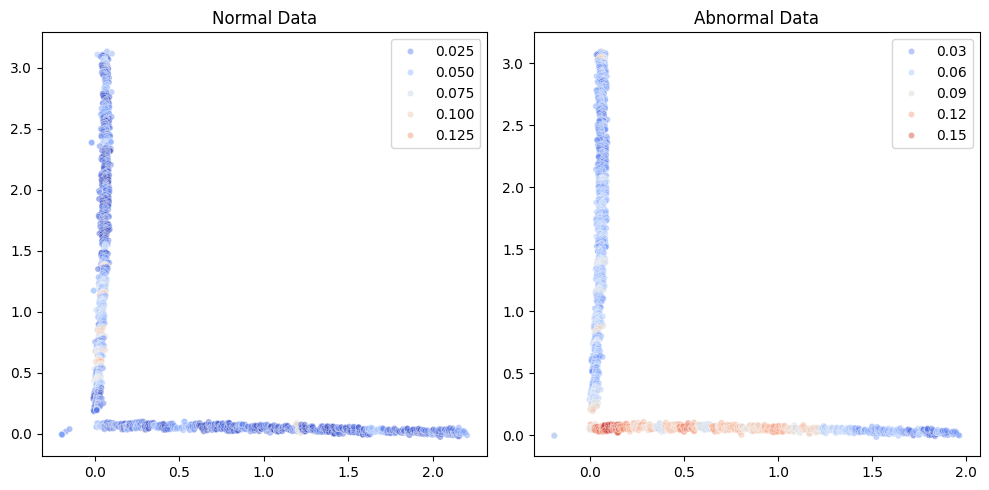

In [93]:
import seaborn as sns
# MSEの全体的な最小値と最大値を計算
mse_min = min(min(mses_normal), min(mses_abnormal))
mse_max = max(max(mses_normal), max(mses_abnormal))

# 正常データのプロット
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=x_test_normal[:, 0],
    y=x_test_normal[:, 1],
    hue=mses_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm',
    hue_norm=(mse_min, mse_max)
)
plt.title('Normal Data')

# 異常データのプロット
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=x_test_abnormal[:, 0],
    y=x_test_abnormal[:, 1],
    hue=mses_abnormal,
    s=20,
    alpha=0.5,
    palette='coolwarm',
    hue_norm=(mse_min, mse_max)
)
plt.title('Abnormal Data')

plt.tight_layout()
plt.show()

In [100]:
def gaussian_2d(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = coords
    xo = float(xo)
    yo = float(yo)
    x = x - xo
    y = y - yo
    sigma_x = float(sigma_x)
    sigma_y = float(sigma_y)

    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)

    g = offset + amplitude * np.exp(-(a * ((x)**2) + 2*b*x*y + c * ((y)**2)))
    return g.ravel()

# データの準備
x_data = x_test_abnormal[:, 0]
y_data = x_test_abnormal[:, 1]
z_data = mses_abnormal

# 初期パラメータの設定
initial_guess = (1, np.mean(x_data), np.mean(y_data), np.std(x_data), np.std(y_data), 0, np.min(z_data))

# フィッティング実行
popt, pcov = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_guess)

# 結果の表示
print("フィット結果: 振幅={}, X中心={}, Y中心={}, X幅={}, Y幅={}, 角度={}, オフセット={}".format(*popt))


フィット結果: 振幅=0.08255242597073514, X中心=0.27662015762168135, Y中心=0.027317502771644672, X幅=0.17092898435496492, Y幅=0.6529922518137401, 角度=1.612574703858251, オフセット=0.04446096595191462


<Axes: >

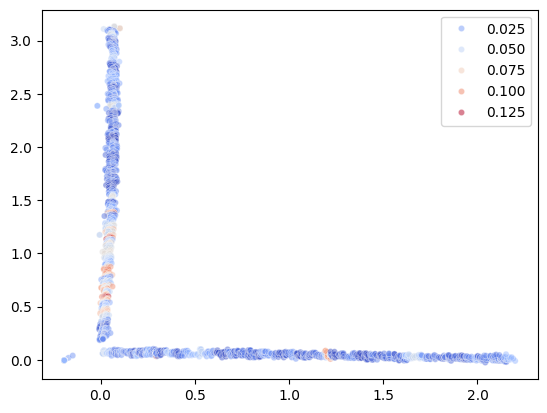

In [101]:
import seaborn as sns
sns.scatterplot(
    x=x_test_normal[:,0],
    y=x_test_normal[:,1],
    hue=mses_normal,
    s=20,
    alpha=0.5,
    palette='coolwarm'
)

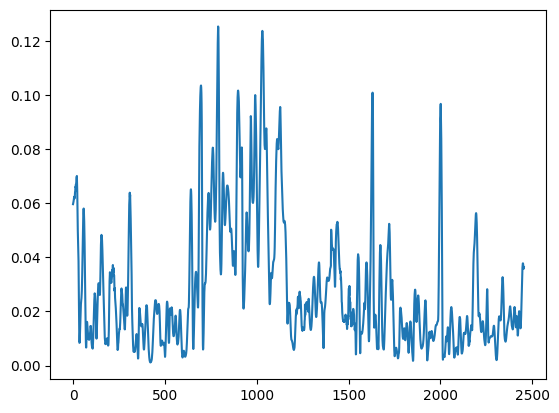

In [102]:
plt.plot(mses_normal)

<Axes: xlabel='mse', ylabel='Count'>

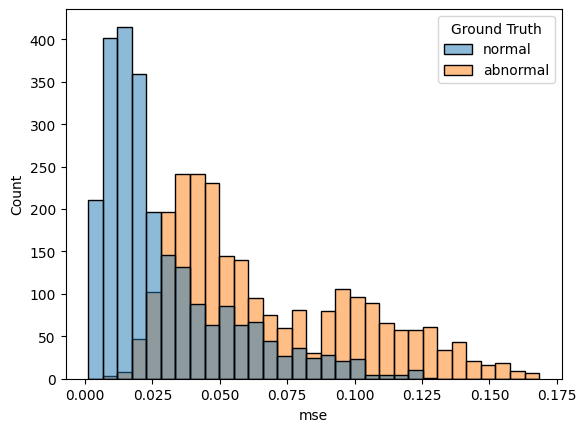

In [103]:
plt_df_normal = pd.DataFrame({'mse':mses_normal})
plt_df_normal['Ground Truth'] = 'normal'
plt_df_abnormal = pd.DataFrame({'mse':mses_abnormal})
plt_df_abnormal['Ground Truth'] = 'abnormal'

plt_df = pd.concat([plt_df_normal, plt_df_abnormal], ignore_index=True)
sns.histplot(
    data=plt_df,
    x='mse',
    hue='Ground Truth'
)


In [104]:
plt_df['Label'] = plt_df['Ground Truth']=='abnormal'
plt_df

,mse,Ground Truth,Label
0,0.059674,normal,False
1,0.059966,normal,False
2,0.060319,normal,False
3,0.060724,normal,False
4,0.061191,normal,False
...,...,...,...
4908,0.028516,abnormal,True
4909,0.029813,abnormal,True
4910,0.031184,abnormal,True
4911,0.032675,abnormal,True


In [105]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Min-Maxスケーリング
scaler = MinMaxScaler()
y_scores_scaled = scaler.fit_transform(np.array(plt_df['mse']).reshape(-1, 1)).flatten()

# AUC計算
auc = roc_auc_score(plt_df['Label'], y_scores_scaled)
# 結果の出力
print(f"AUC: {auc:.4f}")


AUC: 0.8474


In [99]:
plt_df


,mse,Ground Truth,Label
0,0.059674,normal,False
1,0.059966,normal,False
2,0.060319,normal,False
3,0.060724,normal,False
4,0.061191,normal,False
...,...,...,...
4908,0.028516,abnormal,True
4909,0.029813,abnormal,True
4910,0.031184,abnormal,True
4911,0.032675,abnormal,True
